# Поиск каверов композиций
<br>Разработка ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам

<br>**Описание проекта**
<br>Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей.
<br>Если мы умеем с высокой точностью классифицировать каверы и связывать их между собой, то можно предложить пользователю новые возможности для управления потоком треков.
<br>Например:
- по желанию пользователя можем полностью исключить каверы из рекомендаций;
- показать все каверы на любимый трек пользователя;
- контролировать долю каверов в ленте пользователя.

<br>**Цель проекта**
<br>Необходимо разработать ML-продукт, который:
- классифицирует треки по признаку кавер-некавер;
- связывает (группирует) каверы и исходный трек;
- находит исходный трек в цепочке каверов.

<br>**Описание данных**
- Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:
    - track_id - уникальный идентификатор трека;
    - track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
    - original_track_id - уникальный идентификатор исходного трека.
- Метаинформация:
    - track_id - уникальный идентификатор трека;
    - dttm - первая дата появления информации о треке;
    - title - название трека;
    - language - язык исполнения;
    - isrc - международный уникальный идентификатор трека;
    - genres - жанры;
    - duration - длительность трека.
- Текст песен:
    - track_id - уникальный идентификатор трека;
    - lyricId - уникальный идентификатор текста;
    - text - текст трека.

<br>**Целевые метрики**

1. `ROC-AUC` (Receiver Operating Characteristic - Area Under the Curve) является метрикой,
   <br>которая оценивает качество бинарной классификации, учитывая полноту (True Positive Rate) и
   <br>специфичность (True Negative Rate) модели.
   <br>ROC-AUC измеряет способность модели различать между классами и представляет площадь под кривой ROC.
   <br>ROC-AUC особенно полезна, когда важно контролировать баланс между ложно-положительными и ложно-отрицательными предсказаниями.
   <br>Она также устойчива к несбалансированным классам.
3. `F1`-мера является метрикой, которая оценивает точность и полноту модели для бинарной классификации.
   <br>F1-мера является гармоническим средним между точностью (precision) и полнотой (recall).
   <br>Она особенно полезна, когда важно достичь баланса между точностью и полнотой.
   <br>F1-мера хорошо работает, когда классы сбалансированы или когда важно минимизировать как ложно-положительные, так и ложно-отрицательные предсказания.

**План выполнения**
1. Загрузка данных и первичное знакомство с ними;
2. Объединение датафреймов для построения baseline;
3. Кодирование данных для baseline;
4. Получение baseline предсказаний;
5. Дополнение данных признаками:
   - кластеризация;
   - обогащение дополнительными данными из внешних источников;
6. Кодирование дополненных данных;
7. Формирование обучающей и тестовой выборок;
8. Обучение моделей трёх различных структур;
9. Получение предсказаний на кросс-валидации;
10. Подбор гиперпараметров;
11. Выбор лучшей модели;
12. Проверка модели на отложенной выборке;
13. Составление отчёта о проделанной работе.

## Настройка рабочей среды

In [1]:
# !pip install seaborn
# !pip install psycopg2-binary
# !pip install python-dotenv
# !pip install sentence_transformers
# !pip install catboost

In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV

try:
    import mlflow
    import psycopg2 as psycopg
    from dotenv import load_dotenv
except:
    import sys
    from google.colab import drive
    from google.colab import userdata

Установка констант

In [25]:
try:
    load_dotenv()
    connection = {"sslmode": "require",
                  "target_session_attrs": "read-write"}
    postgres_credentials = {"host": os.getenv("DB_HOST"),
                            "port": os.getenv("DB_PORT"),
                            "dbname": os.getenv("DB_NAME"),
                            "user": os.getenv("DB_USERNAME"),
                            "password": os.getenv("DB_PASSWORD")}
    TRACKING_SERVER_HOST = "127.0.0.1"
    TRACKING_SERVER_PORT = 5000
    EXPERIMENT_NAME = 'text_covers'
    RUN_NAME = ['baseline_0_registry', 'logreg_0_registry', 'catboost_1_registry']
    REGISTRY_MODEL_NAME = ['baseline', 'logistic_regression', 'catboost']
    ASSETS_DIR = 'assets/'
    COVERS_PATH = 'data/music_covers.json'
    LYRICS_PATH = 'data/music_lyrics.json'
    META_DATA_PATH = 'data/music_meta.json'
except:
    drive.mount('/content/drive')
    COVERS_PATH = userdata.get('covers')
    LYRICS_PATH = userdata.get('lyrics')
    META_DATA_PATH = userdata.get('meta')

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
sns.set_style("white")
sns.set_theme(style="whitegrid")
pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Импорт класса для проведения исследоваия

In [3]:
try:
    from research_class import DatasetExplorer
except:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(userdata.get('my_module'))
    import research_class
    research_class.DatasetExplorer

## Загрузка данных

In [4]:
covers = pd.read_json(COVERS_PATH, orient='records', lines=True)
lyrics = pd.read_json(LYRICS_PATH, orient='records', lines=True)
meta = pd.read_json(META_DATA_PATH, orient='records', lines=True)

np.array(covers).shape, np.array(lyrics).shape, np.array(meta).shape

((71597, 3), (11414, 3), (71769, 7))

### lyrics

In [6]:
explorer_lyrics = DatasetExplorer(lyrics, target=None)

In [7]:
explorer_lyrics.explore_dataset(assets_dir=None, list_column=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


,lyricId,text,track_id
5908,c417dcedbdb1278d987567fd99f2b31d,У неё на запястье cartie\nВ её бокале bacardi\...,c33f73686c3e6fbe81722e4bd9ceceeb
8949,83128615c4850f2398620440436d1371,Как тебя взять и забыть\nНе встречать тебя вез...,0388be82e560291ab1b3a96a24b6a24d
5665,e143954e84e0e203a3834a2510596548,Mandó Jesús el gran Consolador\nÉl vino con su...,49da7e09a60d43cf88873a6438de9194
3538,33b340743ddafd189d287e1ccc5e3e6a,Come on\nCome on\nCome on\nCome on\nDidn't I m...,544d8a7bb8401b0c7450ed9d6950a1fc
6248,8ab43eb4ac2d8cbad53da17bd9fc794b,"She thinks she missed the train to Mars, she's...",281a1dc64294e48c2b884c3d194ff51d


количество полных дубликатов строк: 0
количество пропущенных значений:
lyricId     0
text        0
track_id    0
dtype: int64
Количество уникальных значений в столбце 'lyricId': 10915
Соотношение уникальных значений и общего количества записей в столбце 'lyricId': 0.96

Количество уникальных значений в столбце 'track_id': 10277
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 0.90



#### Выводы:
- тексты представлены на различных языках (английский, русский, испанский и др.);
- явных повторов строк не обнаружено, при этом количество уникальных ID текстов и треков меньше;
  <br>чем всего строк, что означает использование текстов в других треках;
- пропущенных значений в данных не обнаружено

### meta

In [8]:
explorer_meta = DatasetExplorer(meta, target=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 2   title     71768 non-null  object 
 3   language  21969 non-null  object 
 4   isrc      71455 non-null  object 
 5   genres    71768 non-null  object 
 6   duration  71768 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.8+ MB


,track_id,dttm,title,language,isrc,genres,duration
40169,c0840baaf23114d079939d40d9be37a8,1.672952e+12,Sweet Disposition,EN,USM952300001,"[ROCK, ALLROCK]",234670.0
68734,7c29472522f674da8fe8fb7a5b6b31c1,1.549411e+12,Sunflower,EN,FR10S1938030,[POP],155810.0
33349,22296461d41d5795ef6d4ee0141e51f0,1.644786e+12,Bajo La Luz de la Luna,ES,QZDFP1937971,"[ROCK, ALLROCK]",211750.0
47549,e5f9f58131e23ee65c947e5fdbc81647,1.359922e+12,Demons,EN,USUM71201071,"[ALTERNATIVE, ROCK, ALLROCK]",177500.0
24617,45bf1523b6b064ac3ccdd157c2ee2af2,1.623426e+12,Shape Of You,EN,QZGWX2211972,"[POP, DANCE]",161950.0


количество полных дубликатов строк: 0
количество пропущенных значений:
track_id        1
dttm            1
title           1
language    49800
isrc          314
genres          0
duration        1
dtype: int64


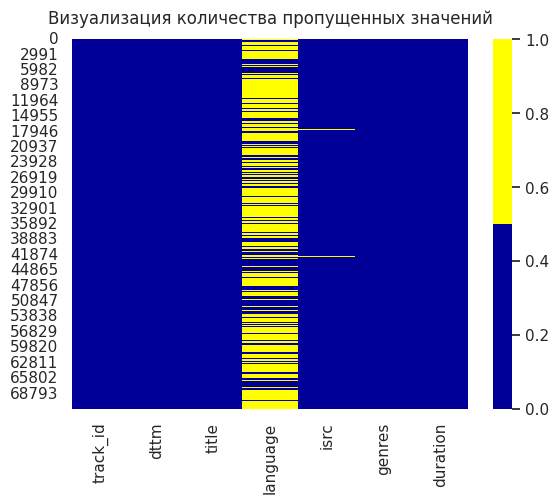

Процент пропущенных значений в признаках:
track_id: 0.00%
dttm: 0.00%
title: 0.00%
language: 69.39%
isrc: 0.44%
duration: 0.00%
Количество уникальных значений в столбце 'track_id': 71768
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00



In [9]:
explorer_meta.explore_dataset(assets_dir=None, list_column='genres')

In [10]:
print(f"Количество уникальных записей language: {meta['language'].nunique()}")

Количество уникальных записей language: 85


#### Выводы:
- явных повторов строк не обнаружено;
- количество стран в колонке `language` - 85;
- информацию о страннах имеют около 30% записей;
- все `track_id` уникальны;
- даты представлены в unix формате;
- можно удалить признаки:
  - `duration` - не несёт важной информации, т.к. продолжительность кавера может отличаться от исходника
  - `genres` - не несёт важной информации, т.к. жанр кавера может отличаться от исходника
  - `isrc` - не несёт важной информации, т.к. имеется признак `track_id`, а ещё в нём есть пропуски

### covers

In [11]:
explorer_covers = DatasetExplorer(covers, target='track_remake_type')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


,original_track_id,track_id,track_remake_type
48596,None,36bc4babedd00e207fad95f834a79e33,COVER
39189,None,951a24ddad24ca432766236946cb6d66,COVER
48106,None,a9a33d68fd3c250487e63b786741d1b4,COVER
62168,None,55ea4ce19deb461086c13c23c17d2b46,COVER
49151,None,3ac81da3dde2e751f8b8ce85c7952606,COVER


количество полных дубликатов строк: 0
количество пропущенных значений:
original_track_id    66776
track_id                 0
track_remake_type        0
dtype: int64


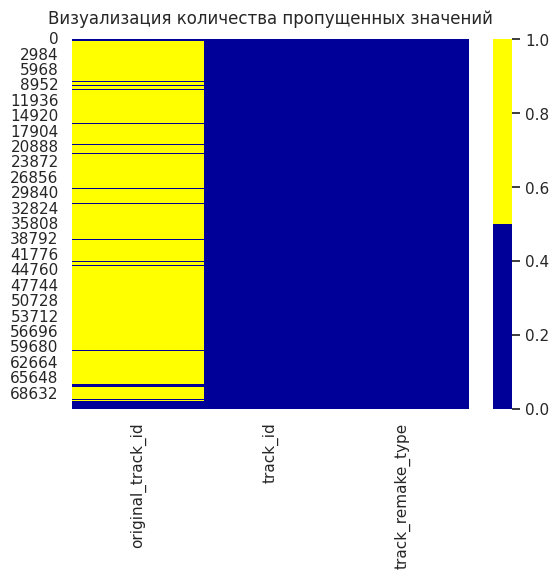

Процент пропущенных значений в признаках:
original_track_id: 93.27%
Количество уникальных значений в столбце 'original_track_id': 4468
Соотношение уникальных значений и общего количества записей в столбце 'original_track_id': 0.06

Количество уникальных значений в столбце 'track_id': 71597
Соотношение уникальных значений и общего количества записей в столбце 'track_id': 1.00

Соотношение классов целевой переменной:
			track_remake_type
ORIGINAL     4293
COVER       67304
Name: count, dtype: int64


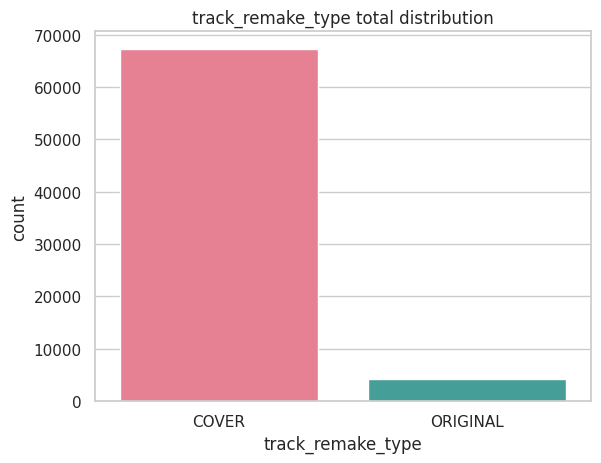

In [12]:
explorer_covers.explore_dataset(assets_dir=None, list_column=None)

In [13]:
print(f"Оригинальных треков указано: {round(covers['original_track_id'].count() / covers['track_id'].count() * 100, 2)}% записей")

Оригинальных треков указано: 6.73% записей


#### Выводы:
- дубликатов строк не обнаружено;
- все `track_id` уникальны;
- классы целевой переменной крайне несбалансированы:
  <br>количество указанных оригинальных треков - 6.73 % от общего числа треков

### Формирование baseline датафрейма

In [5]:
covers_base = covers.copy()
covers_base.dropna(subset='original_track_id', inplace=True)
cover_lyric = (covers_base
               .merge(lyrics, on='track_id', how='left')
               .merge(meta, on='track_id', how='left')
              )

cover_lyric.dropna(subset=['text'], inplace=True)
cover_lyric.reset_index(inplace=True)

Формирование списков признаков

In [6]:
ids = [col for col in cover_lyric.columns if 'id' in col.lower()]
ids.append('isrc')
target = ['track_remake_type']
num_features = cover_lyric.select_dtypes(include=['number']).columns
text_features = ['text']

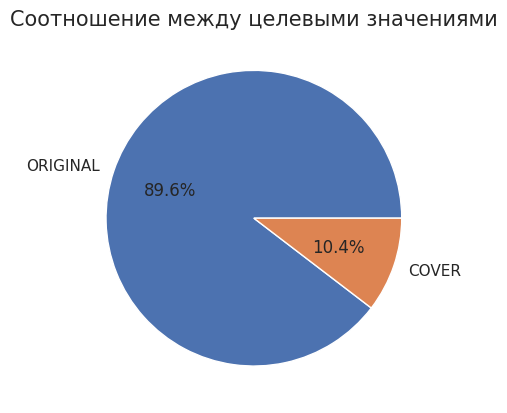

In [7]:
labels = cover_lyric['track_remake_type'].value_counts().index
sizes = [cover_lyric['track_remake_type'].value_counts().iloc[0],
         cover_lyric['track_remake_type'].value_counts().iloc[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Соотношение между целевыми значениями', size=15)
plt.savefig(os.path.join(ASSETS_DIR, f'target distribution in baseline data.png'))
plt.show()

#### Вывод:
- данные объединены;
- удалены пропущенные тексты;
- сформированы списки признаков;
- проверен баланс классов в сформированном датафрейме.

## Подготовка данных для обучения

In [10]:
explorer_data = DatasetExplorer(cover_lyric, target=target)

### baseline_data

In [13]:
target, X_train_base, X_test_base, y_train_base, y_test_base = explorer_data.data_preprocessing(text_sentences=text_features,
                                                                                                target_encoder='LabelEncoder',
                                                                                                data_columns=['dttm', 'duration', 'is_cover'],
                                                                                                cluster_model='KMeans',
                                                                                                data_type='baseline_data',
                                                                                                assets_dir=None)

Размерность таблицы эмбеддингов: (3599, 768)
Размерности полученных выборок: ((3239, 768), (360, 768), (3239,), (360,))


### main_data

Размерность таблицы эмбеддингов: (3599, 768)


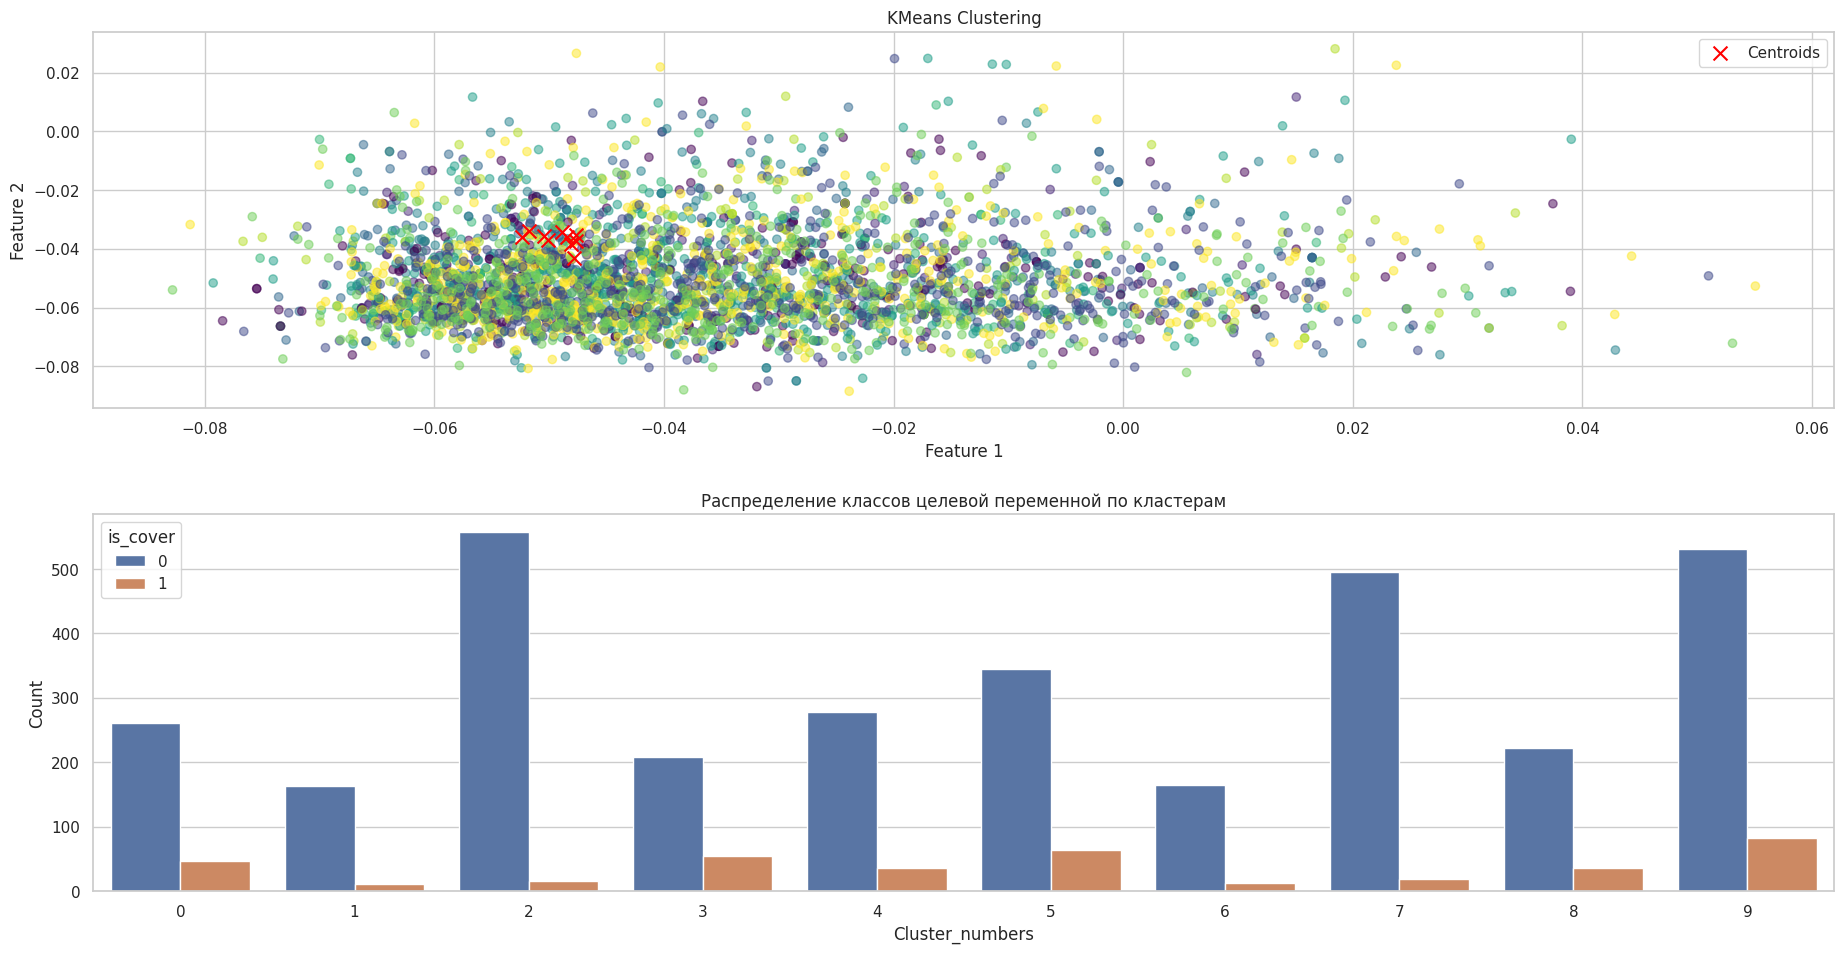

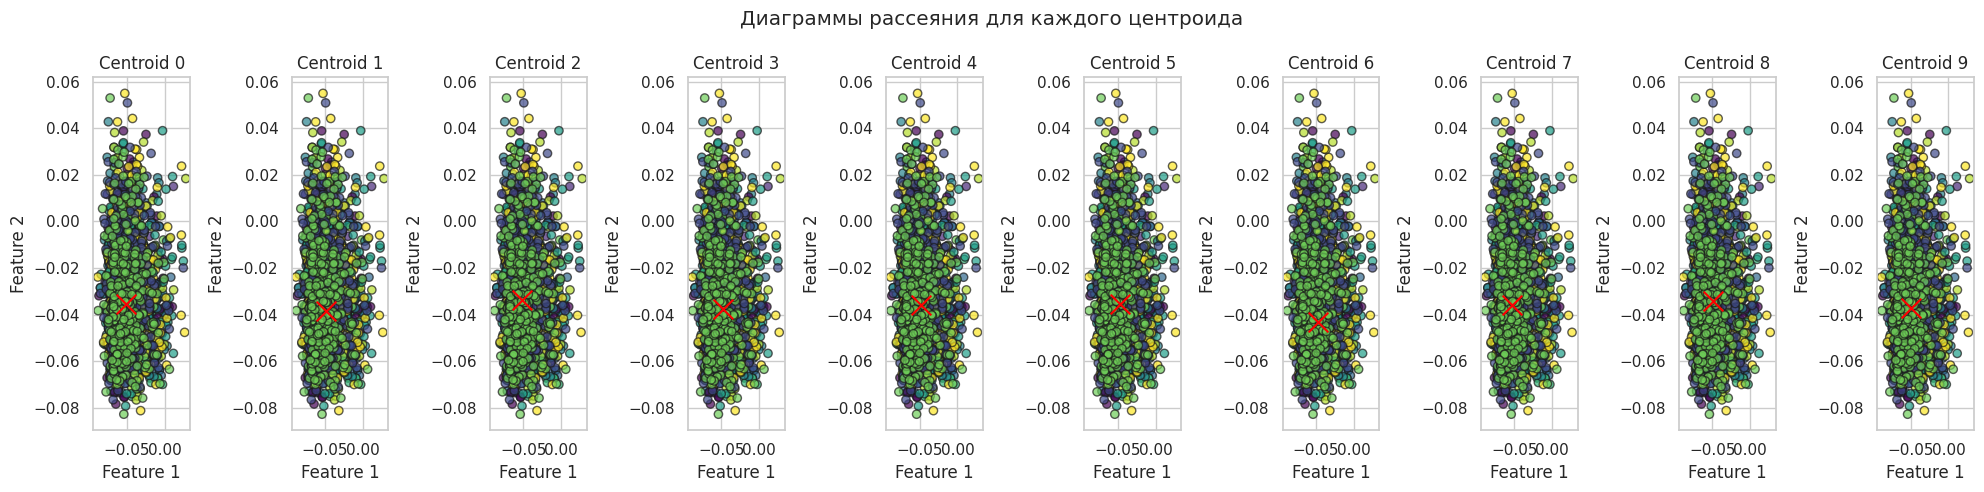

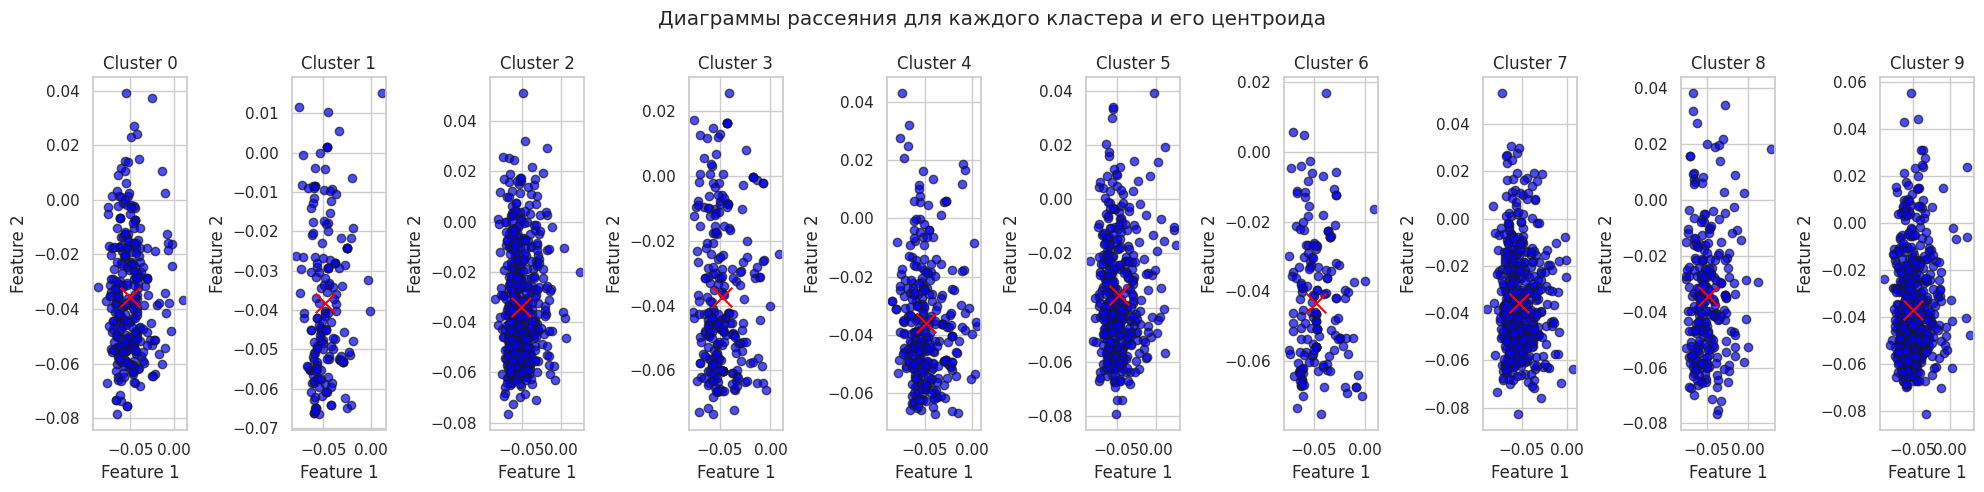

Размерности полученных выборок: ((3239, 771), (360, 771), (3239,), (360,))


In [15]:
target, X_train, X_test, y_train, y_test = explorer_data.data_preprocessing(text_sentences=text_features,
                                                                            target_encoder='LabelEncoder',
                                                                            data_columns=['dttm', 'duration', 'is_cover'],
                                                                            cluster_model='KMeans',
                                                                            data_type='main_data',
                                                                            assets_dir=None)

### Вывод:
- получены эмбеддинги текстов и наименований при помощи библиотеки `sentence_transformer` на архитектуре LaBSE;
- выбор данной архитектуры обусловлен её способностью распознавать и сравнивать тексты на более, чем 100 языках;
- наименования могут быть потенциальным источником утечки данных, поэтому их использование пока не предполагается;
- значения целевой переменной закодированы в числа;
- произведена кластеризация данных методом `k-means`;
- данные разделены на обучающую и тестовую выборки.

## Обучение моделей

### Baseline

Результаты кросс-вадидации: {'fit_time': 0.149, 'score_time': 0.025, 'test_roc_auc': 0.883, 'test_f1': 0.46}


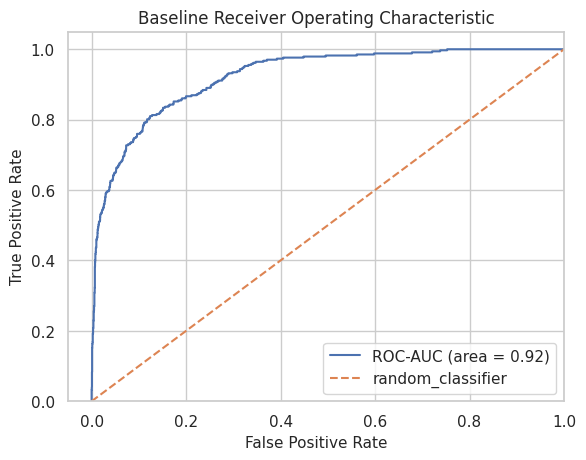

In [18]:
baseline_params = {'class_weight':'balanced',
                   'C':1.0,
                   'penalty':'l2',
                   'max_iter':1000,
                   'random_state':RANDOM_STATE}

cv_res, baseline = explorer_data.model_fitting(model_name='Baseline',
                                               features_train=X_train_base,
                                               target_train=y_train_base,
                                               params=baseline_params,
                                               params_search=False,
                                               assets_dir=None)

Вывод:

- в качестве базовой модели принята `LogisticRegression` на минимальном наборе данных;
- при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.877`, `F1-мера: 0.491`;
- модель с гиперпараметрами и метриками сохранена.

### CatBoost

Результаты кросс-вадидации: {'fit_time': 18.063, 'score_time': 0.106, 'test_roc_auc': 0.903, 'test_f1': 0.608}


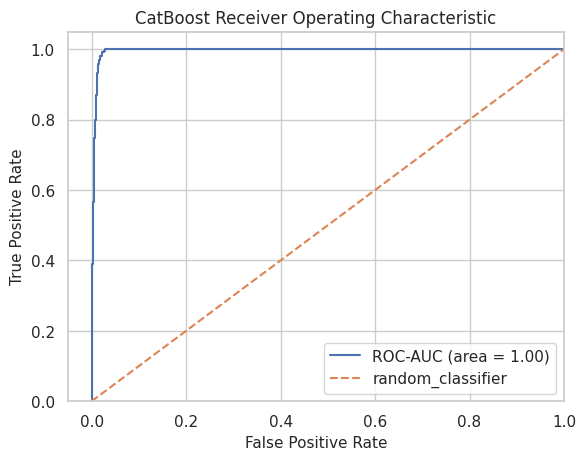

In [29]:
cb_params = {'iterations': 300,
             'max_depth': 3,
             'auto_class_weights':'Balanced',
             'verbose': False,
             'random_state': RANDOM_STATE}

cv_res, model_cb = explorer_data.model_fitting(model_name='CatBoost',
                                               features_train=X_train,
                                               target_train=y_train,
                                               params=cb_params,
                                               params_search=False,
                                               assets_dir=None)

Вывод:
- обучена модель `CatBoost` на минимальном наборе данных:
  - при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.915`, `F1-мера: 0.665`;
- обучена модель `CatBoost` на основном наборе данных:
  - при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.903`, `F1-мера: 0.608`;
- все модели с гиперпараметрами и метриками сохранены.

### Logistic Regression

Результаты кросс-вадидации: {'fit_time': 0.637, 'score_time': 0.065, 'test_roc_auc': 0.633, 'test_f1': 0.126}


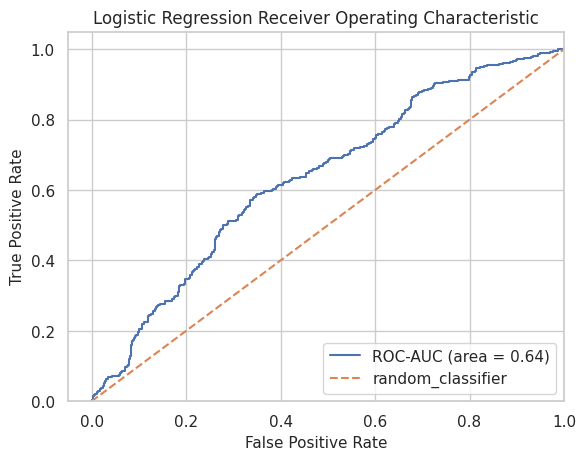

In [50]:
lr_params = {'class_weight':'balanced',
             'C':1.0,
             'penalty':'l2',
             'max_iter':1000,
             'random_state':RANDOM_STATE}

cv_res, model_lr = explorer_data.model_fitting(model_name='Logistic Regression',
                                               features_train=X_train,
                                               target_train=y_train,
                                               params=lr_params,
                                               params_search=False,
                                               assets_dir=None)

- обучена модель `Logistic Regression` на основном наборе данных:
  - при её обучении с использованием кросс-валидации получены метрики `ROC-AUC: 0.633`, `F1-мера: 0.126`;
- все модели с гиперпараметрами и метриками сохранены.

In [51]:
# Логирование эксперимента
# !pip freeze > requirements.txt
pip_requirements = "requirements.txt"
signature = mlflow.models.infer_signature(X_train.values, y_train.values)
metadata = {
    "author": 'denis_zeit',
    "training_date": '2024-04-12',
    "data_used": 'main_data',
    "library_versions": {"mlflow": "2.11.3",
                         # "catboost": "1.2.3",
                         "scikit-learn": "1.4.2",
                         "sentence-transformers": "2.6.1"}
}
input_example = (X_train).iloc[0].to_dict()
code_paths = ['music_covers.ipynb', 'research_class.py']

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
experiment_id = mlflow.set_experiment(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME[1], experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_params(lr_params)
    mlflow.log_metrics(cv_res)
    model_info = mlflow.sklearn.log_model(
        sk_model=model_lr,
        artifact_path="models",
        pip_requirements=pip_requirements,
        signature=signature,
        input_example=input_example,
        metadata=metadata,
        code_paths=code_paths,
        registered_model_name=REGISTRY_MODEL_NAME[1],
        await_registration_for=60
		)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
run = mlflow.get_run(run_id)
assert run.info.status == "FINISHED"

/home/denis/Documents/main_venv/music_covers/.env_mc/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/denis/Documents/main_venv/music_covers/.env_mc/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'logistic_regression'.
2024/04/12 18:07:49 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: logistic_regression, version 1
Created version '1' of m

## Выбор лучшей модели

In [53]:
connection.update(postgres_credentials)
with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        # cur.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
        # table_data = []
        # for table_name in cur.fetchall():
        #     cur.execute(f"SELECT COUNT(*) FROM {table_name[0]}")
        #     table_data.append((table_name[0], cur.fetchone()[0]))
        # print('Находящиеся в базе таблицы:')
        # display(pd.DataFrame(table_data, columns=['table_name', 'number_of_rows']))

        cur.execute("""
                       SELECT
                         model_versions.name AS model_name,
                         model_versions.version,
                         STRING_AGG(metrics.key || '=' || metrics.value, '; ') AS metrics,
                         metrics.run_uuid
                       FROM metrics
                         LEFT JOIN model_versions ON model_versions.run_id=metrics.run_uuid
                       WHERE metrics.key NOT IN ('fit_time', 'score_time') AND model_versions.name IS NOT NULL
                       GROUP BY model_versions.name, model_versions.version, metrics.run_uuid
                       ORDER BY metrics DESC
                       """)
        table_data = cur.fetchall()
        table_columns = [desc[0] for desc in cur.description]
        print('Модели и их метрики:')
        display(pd.DataFrame(table_data, columns=table_columns))

Модели и их метрики:


,model_name,version,metrics,run_uuid
0,catboost,1,test_roc_auc=0.915; test_f1=0.665,00859330fee246519afef44d1899ddd8
1,catboost,2,test_roc_auc=0.903; test_f1=0.608,7781b14c54ef4117a961a8f3148076a0
2,baseline,1,test_roc_auc=0.877; test_f1=0.491,d2528065e13f42208db937556efd84bf
3,logistic_regression,1,test_roc_auc=0.633; test_f1=0.126,64c8c0aa917e45359de23d2aa19a5bf1


## Заключение:
- в решении поставленной задачи основными признаками приняты эмбеддинги текстов;
- целевой метрикой выбрана `roc-auc`, т.к. она устойчива к дисбалансу классов, который присущ предоставленным данным;
- при кодировании текстов использован трансформер на архитектуре `LaBSE` из библиотеки `SentenceTransformer`;
- целевой признак - метка оригинал/кавер
- удалённые признаки:
  - `ID` треков и текстов (чтобы модель была более универсальной);
  - текст - удалён, т.к. есть его эмбеддинги;
  - язык, продолжительность, жанр - удалены, т.к. сами по себе данные признаки не информативны для решения поставленной задачи;
- признаки поделены на кластеры при помощи алгоритма `KMeans`;
- при обучении выбирали лучшую из моделей: `CatBoost`, `LogisticRegression`;
- наилучший результат по выбранной метрике показала модель: `CatBoost` на эмбеддингах, без использования дополнительных признаков;
- не реализованные идеи:
  - пробовали использовать библиотеку MusicMetaLinker для обогащения предоставленных данных, но для полноценного использования не хватило отведённого времени
  - рассматривали алгоритм Doc2Vec, для полноценного изучения не хватило времени